In [5]:
from __future__ import print_function, division
import requests
import re
import pandas as pd
import dateutil.parser
import datetime
import pickle
import patsy
import numpy as np
from pprint import pprint
from bs4 import BeautifulSoup
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from seaborn import plt
%matplotlib inline


## Cache magic

In [96]:
import os
import uuid

_cache = None
_cache_dir = "./cache"
_cache_index = os.path.join(_cache_dir, 'index.pkl')

def cache_init():
    global _cache
    if _cache == None:
        if os.path.exists(_cache_index):
            with open(_cache_index, 'rb') as fd:
                _cache = pickle.load(fd)
        else:
            _cache = {}
    return _cache

def cache_get(key):
    return cache_init().get(key, '')

def cache_add(key, value):
    cache = cache_init()
    cache[key] = value
    with open(_cache_index, 'wb') as fd:
       pickle.dump(cache, fd)

def get_page(url):
    """Get a web page."""

    # Check if we have this page
    
    filename = cache_get(url)
    if filename and os.path.exists(filename):
        with open(filename, 'rb') as fd:
            return fd.read()

    # Otherwise, download the page ...
    
    r = requests.get(url, timeout=10)
    r.raise_for_status()
    
    # ... and cache it

    global _cache_dir
    if not os.path.isdir(_cache_dir):
        os.mkdir(_cache_dir)
        
    if not filename:
        filename = os.path.join(_cache_dir, uuid.uuid4().hex)

    with open(filename, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=4096):
            fd.write(chunk)

    cache_add(url, filename)
    
    return r.text

In [97]:
# functions

def to_date(datestring):
    datetime = dateutil.parser.parse(datestring)
    return datetime.date()

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text 
    else:
        return None

## Obtain list of movie URLs for five years

In [26]:
mov_urls = []
for year in range(2012,2017):

    url = "http://www.boxofficemojo.com/yearly/chart/?view2=worldwide&yr=" + str(year) + "&p=.htm"

    response=requests.get(url)
    page=response.text

    soup=BeautifulSoup(page,"lxml")

    tables=soup.find_all("table")
    rows=[row for row in tables[2].find_all('tr')][3:]

    mov_urls_individual = []
    for j in rows:
        snippet = j.find('a')['href']
        mov_urls_individual.append(snippet.split("=")[1])
    
    
    print(len(mov_urls_individual))
    mov_urls += mov_urls_individual
print(len(mov_urls))

397
347
390
448
409
1991


In [75]:
#test_url = mov_urls[3:13]

In [108]:
movies_df = pd.DataFrame(columns = ['movie_title', 'domestic_total_gross',
           'release_date', 'distributor', 'genre', 'budget', 'runtime_mins', 'directors', 'writers', 'actors', 'producers', 'rating', "no_countries", "widest_release", "days_in_release"])

def scrape_movie():
        
    for iu in mov_urls[1920:]:   
        
        url = 'http://www.boxofficemojo.com/movies/?id=' + iu        
        response = requests.get(url) #Pulls data
        page = response.text
        #page = get_page(url)
        
        soup = BeautifulSoup(page,"lxml") # lxml is an optional add-on

        # Title
        title_string = soup.find('title').text
        title = title_string.split('(')[0].strip()

        # Finding domestic lifetime gross from lower table
        try:
            rev_table = soup.find_all("table")[9]
            dom_lt_gross = rev_table.find_all("td")[1].text
            dom_lt_gross = dom_lt_gross.replace("$", "").replace(",", "")
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            dom_lt_gross = np.nan

        # Release Date
        raw_release_date = get_movie_value(soup,'Release Date')
        release_date = raw_release_date
        
        # Distributor
        try:
            distributor = get_movie_value(soup,'Distributor')
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            distributor = np.nan

        # Genre
        try:
            genre = get_movie_value(soup,'Genre: ')
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            genre = np.nan

        # Production Budget
        try:
            budgetcell = get_movie_value(soup,'Production Budget')
            if "million" in budgetcell:
                budget = float(budgetcell[1:budgetcell.find(" ")])
            else:
                budget = np.nan
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            budget = np.nan
            
        # Runtime
        try:
            raw_runtime = get_movie_value(soup,'Runtime')
            runtime = runtime_to_minutes(raw_runtime)
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            runtime = np.nan

        # Directors, Writers, Actors, Producers
        try:
            players_table = soup.find_all("table")[14]
            cells = players_table.find_all("td")
            
            directors = np.nan
            writers = np.nan
            actors = np.nan
            producers = np.nan
            
            for i in range(len(cells)):
                if re.match("Director", cells[i].text):
                    individuals = cells[i+1].find_all('a')
                    directors = []
                    for indiv in individuals:
                        directors.append(indiv.text)
 
                if re.match("Writer", cells[i].text):
                    individuals = cells[i+1].find_all('a')
                    writers = []
                    for indiv in individuals:
                        writers.append(indiv.text)

                if re.match("Actor", cells[i].text):
                    individuals = cells[i+1].find_all('a')
                    actors = []
                    for indiv in individuals:
                        actors.append(indiv.text)
 
                if re.match("Producer", cells[i].text):
                    individuals = cells[i+1].find_all('a')
                    producers = []
                    for indiv in individuals:
                        producers.append(indiv.text)
 
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            directors = np.nan
            writers = np.nan
            actors = np.nan
            producers = np.nan

        # Rating
        rating = get_movie_value(soup,'MPAA Rating')
        
        # Countries
        try:
            int_url = "http://www.boxofficemojo.com/movies/?page=intl&id=" + iu
            int_response=requests.get(int_url)
            int_page=int_response.text
            int_soup=BeautifulSoup(int_page,"lxml")
            country_table = int_soup.find_all("table")[7]
            no_countries = len(country_table.find_all("tr")) - 3
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            no_countries = np.nan

        
        # Theaters (Widest Release)
        try:
            wr_regex = re.compile('Release:')
            wr = soup.body.find(text=wr_regex)
            wr_int = wr.findNext("td").text.split(" ")[0].replace(",", "")
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            wr_int = np.nan

            
        # Release Time (in days)
        try:
            ir_regex = re.compile('In Release:')
            ir = soup.body.find(text=ir_regex)
            ir_int = ir.findNext("td").text.split(" ")[0].replace(",", "")
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            ir_int = np.nan
        
        # New Row
        new_row = [title, dom_lt_gross, release_date, distributor, genre, budget, runtime, directors, writers, actors, producers, rating, no_countries, wr_int, ir_int]

        movies_df.loc[len(movies_df)] = new_row


scrape_movie()

print("movies_df:")
movies_df.head()

movies_df:


,movie_title,domestic_total_gross,release_date,distributor,genre,budget,runtime_mins,directors,writers,actors,producers,rating,no_countries,widest_release,days_in_release
0,Cemetery of Splendor,51950,"March 4, 2016",Strand,Drama,NaN,122,NaN,NaN,NaN,NaN,Unrated,5.0,6,98
1,Unable to Process,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
2,In the Shadow of Women,50291,"January 15, 2016",Distrib Films,Drama,NaN,73,NaN,NaN,NaN,NaN,Unrated,7.0,4,87
3,In Order of Disappearance,50251,"August 26, 2016",Magnolia,Action Comedy,NaN,114,NaN,NaN,NaN,NaN,R,9.0,10,28
4,Pele: Birth of a Legend,49979,"May 13, 2016",IFC,Sports Drama,NaN,107,NaN,NaN,"[Seu Jorge, Rodrigo Santoro]",NaN,PG,9.0,19,28


## Formatting of data frame

In [126]:
# format columns

def integ(floatt):
    try:
        return int(floatt)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')

def floatt(grossstr):
    try:
        return float(grossstr)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')


def tdelta(days):
    try:
        return datetime.timedelta(days)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')


def todate(strdate):
    try:
        return dateutil.parser.parse(strdate)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')


def tdelta(days):
    try:
        return datetime.timedelta(days)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')


def format_series(df):
    # Convert runtime into mins
    df["runtime_mins"] = df["runtime_mins"].apply(integ)
    # Convert widest_release to int
    df["widest_release"] = df["widest_release"].apply(integ)
    # Convert budget to int
    df["budget"] = df["budget"].apply(integ)
    # Convert days_in_release to int
    df["days_in_release"] = df["days_in_release"].apply(integ)
    # Convert domestic_total_gross to float
    df["domestic_total_gross"] = df["domestic_total_gross"].apply(floatt)
    # Convert release_date to datetime.date
    df["release_date"] = df["release_date"].apply(todate)
    # Calculate close_date from release_date and days_in_release
    #df["close_date"] = df["release_date"] + df["days_in_release"].apply(tdelta)

format_series(movies_df)

In [127]:
# pickle movies_df
movies_df.to_pickle('movies_df.pkl')

In [125]:
# Unpickle movies_df
with open('movies_df.pkl', 'rb') as picklefile: 
    movies_df = pickle.load(picklefile)

In [128]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1984 entries, 0 to 70
Data columns (total 15 columns):
movie_title             1984 non-null object
domestic_total_gross    1937 non-null float64
release_date            1982 non-null datetime64[ns]
distributor             1982 non-null object
genre                   1982 non-null object
budget                  544 non-null float64
runtime_mins            1946 non-null float64
directors               788 non-null object
writers                 648 non-null object
actors                  957 non-null object
producers               592 non-null object
rating                  1982 non-null object
no_countries            1982 non-null float64
widest_release          1958 non-null float64
days_in_release         1801 non-null float64
dtypes: datetime64[ns](1), float64(6), object(8)
memory usage: 248.0+ KB


### Exclude feature I won't use for now

In [148]:
movies_short_df = movies_df.drop(["release_date", "distributor", "directors", "writers", "actors", "producers", "days_in_release", "budget"], axis=1)

In [149]:
movies_short_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1984 entries, 0 to 70
Data columns (total 7 columns):
movie_title             1984 non-null object
domestic_total_gross    1937 non-null float64
genre                   1982 non-null object
runtime_mins            1946 non-null float64
rating                  1982 non-null object
no_countries            1982 non-null float64
widest_release          1958 non-null float64
dtypes: float64(4), object(3)
memory usage: 124.0+ KB


In [150]:
# drop nas
movies_short_df.dropna(inplace=True)

In [151]:
len(movies_short_df)

1897

In [152]:
# pickle movies_short_df
movies_short_df.to_pickle('movies_short_df.pkl')

In [159]:
# Unpickle movies_short_df
with open('movies_short_df.pkl', 'rb') as picklefile: 
    movies_short_df = pickle.load(picklefile)

## Regression Analysis

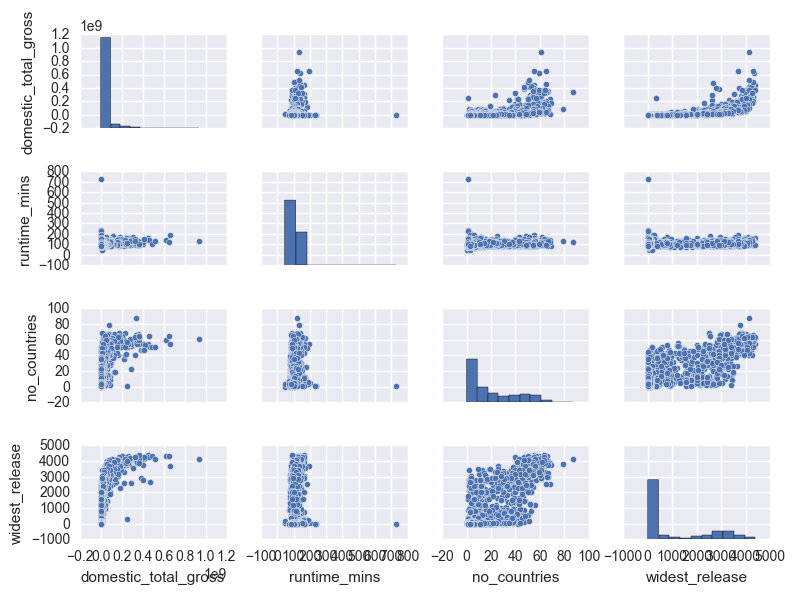

In [160]:
sns.pairplot(movies_short_df, size = 1.5, aspect=1.3)

In [161]:
# Initial Regression

lr = LinearRegression() # creates empty model
X = movies_short_df[['runtime_mins', 'no_countries', 'widest_release']]
y = movies_short_df['domestic_total_gross']
lr.fit(X,y) # fit model to full dataset
lr.score(X,y) # print out R^2 for model

0.46327945311278151

In [162]:
# transform to logs
movies_short_df['log_dtg'] = np.log(movies_short_df['domestic_total_gross'])
movies_short_df['log_runtime_mins'] = np.log(movies_short_df['runtime_mins'])
movies_short_df['log_no_countries'] = np.log(movies_short_df['no_countries'])
movies_short_df['log_widest_release'] = np.log(movies_short_df['widest_release'])

In [164]:
movies_short_df.corr()['log_dtg'].sort_values(ascending=False)

log_dtg                 1.000000
log_widest_release      0.948471
widest_release          0.845724
no_countries            0.761862
log_no_countries        0.711908
domestic_total_gross    0.583159
log_runtime_mins        0.163731
runtime_mins            0.119903
Name: log_dtg, dtype: float64

In [167]:
# Redo Regression with improved R^2

# Run regression again on log domestic total gross and log features
y, X = patsy.dmatrices('log_dtg ~ log_widest_release + runtime_mins + no_countries', data=movies_short_df, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dtg   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     6169.
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        21:27:24   Log-Likelihood:                -2658.9
No. Observations:                1897   AIC:                             5326.
Df Residuals:                    1893   BIC:                             5348.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              7.6058      0.113     67.356      0.000         7.384     7.827
log_widest_release     1.0849      0.013     81.014      0.000         1.059     1.111
runtime_mins           0.0062      0.001      6.577      0.000         0.004     0.008
no_countries           0.0185      0.002     10.522      0.000         0.015     0.022
==============================================================================
Omnibus:                      117.553   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              356.315
Skew:                          -0.279   Prob(JB):                     4.24e-78
Kurtosis:                       5.048   Cond. No.                         570.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Diagnose Assumptions

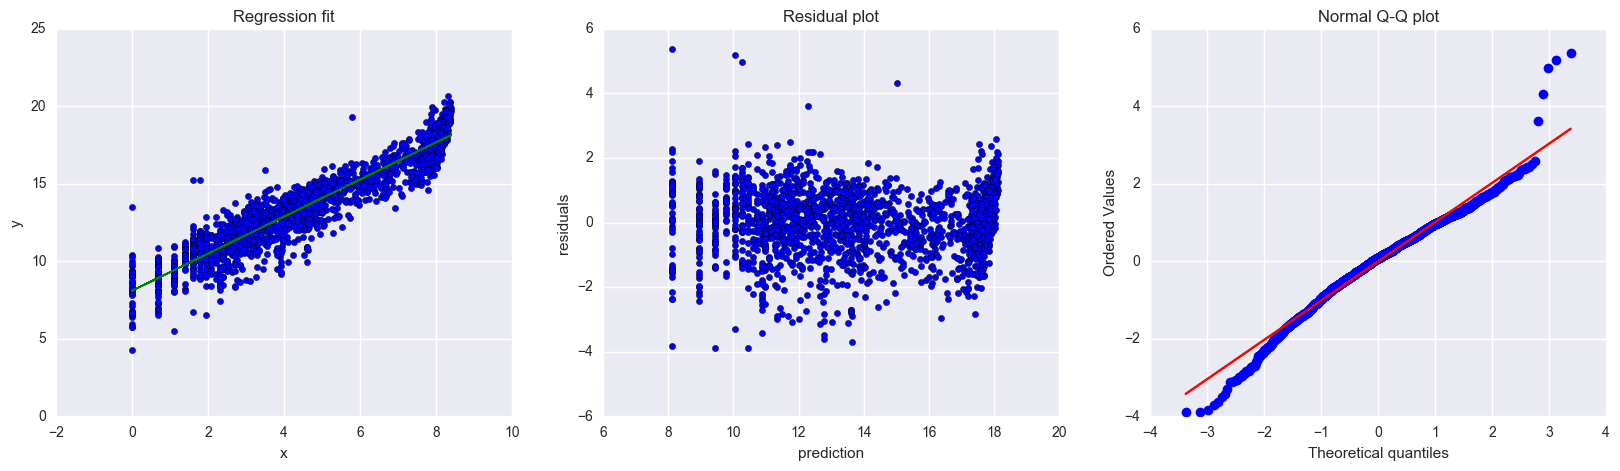

In [168]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='green',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

s= 1897

diagnostic_plot(movies_short_df['log_widest_release'], movies_short_df['log_dtg'])

## Investigate polynomial due to perceived heteroscedasticity

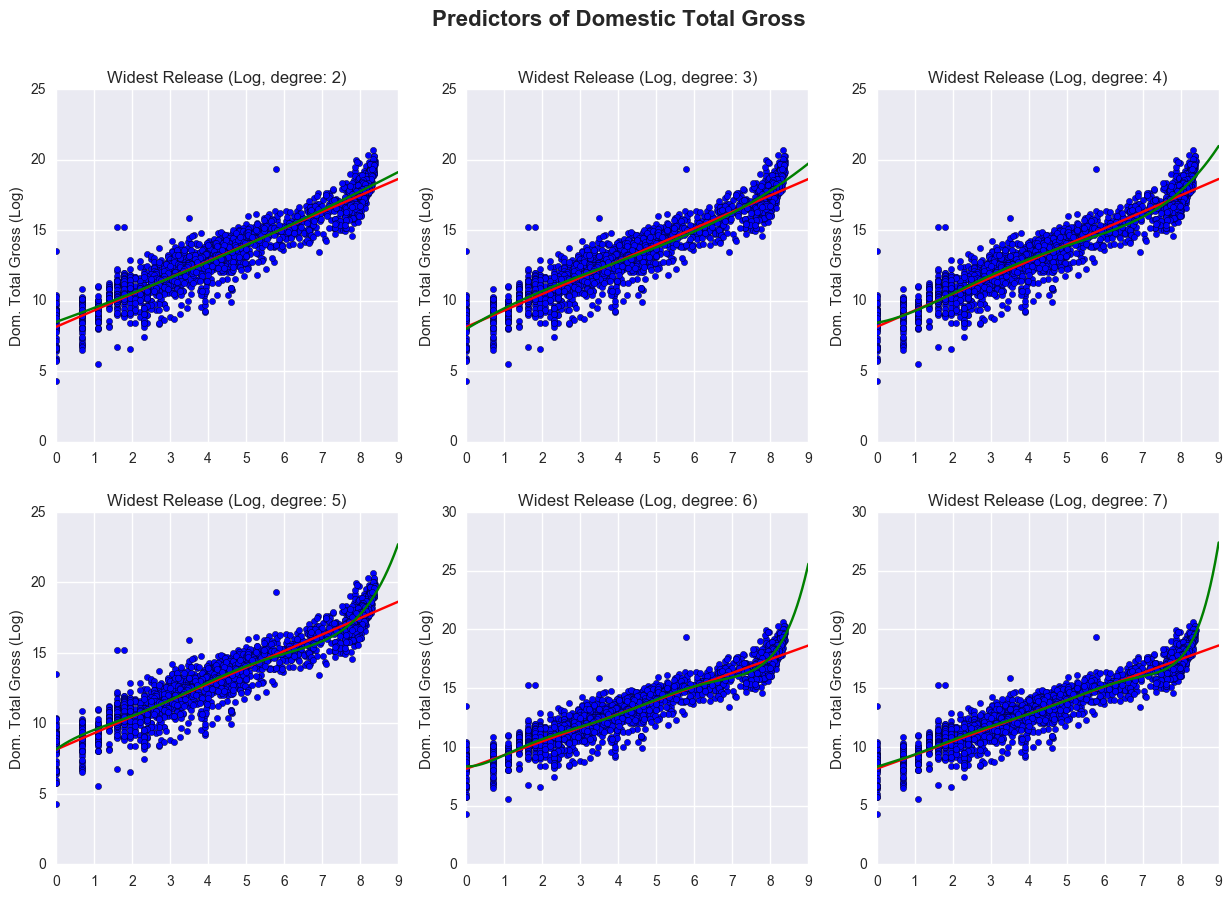

In [171]:
subplotdict = {2:231, 3:232, 4:233, 5:234, 6:235, 7:236}

X = movies_short_df["log_widest_release"].reshape((1897, 1))

for degree in range(2,8):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X, movies_short_df["log_dtg"])

    fig = plt.figure(num=1, figsize=(8,6))
    fig.set_size_inches(15, 10, forward=False)
    fig.suptitle('Predictors of Domestic Total Gross', fontsize=16, fontweight='bold')

    # log_widest_release
    x_plot = np.linspace(0,9, num = 1897)

    plt.subplot(subplotdict[degree])
    plt.scatter(x=X, y=movies_short_df["log_dtg"], label="log_widest_release")
    plt.plot(x_plot, lwr(x_plot), color="red")
    plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='green', label="polynomial")
    plt.title('Widest Release (Log, degree: ' + str(degree) + ")")
    plt.ylabel("Dom. Total Gross (Log)")
    plt.xlim(0, 9)
    plt.grid(True)

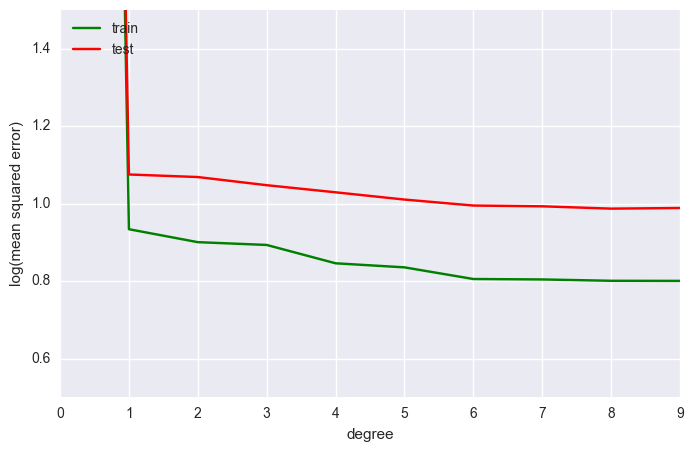

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, movies_short_df["log_dtg"], test_size=0.8)

from sklearn.metrics import mean_squared_error

train_error = np.empty(10)
test_error = np.empty(10)

for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,5))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.5, 1.5))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')

/Users/maxkneissl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/maxkneissl/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/maxkneissl/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/maxkneissl/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


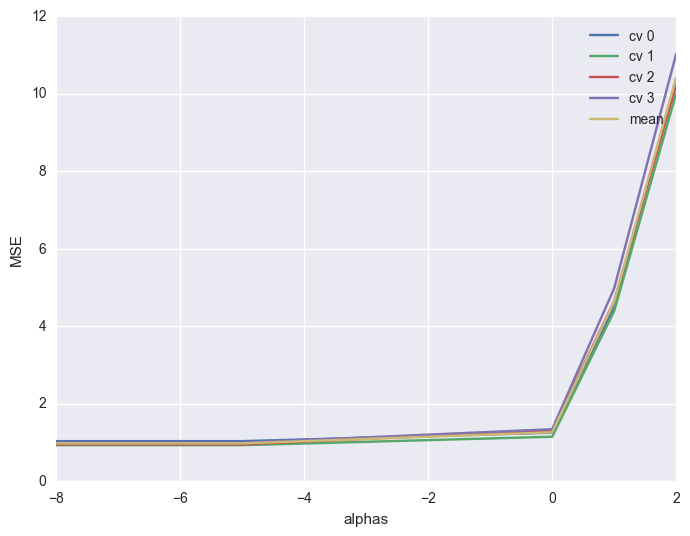

In [177]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


def pick_alpha(fold, X, y):
    kf = KFold(n=len(X), n_folds=fold, shuffle=True)
    
    all_scores=[]
    alphas = [0.0, 1e-8, 1e-5, 1, 10, 100]

    for train, test in kf:
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        mse_score=[]
        for a in alphas:
            est=Lasso(alpha=a)
            est.fit(x_train,y_train)
            mse=np.mean((y_test-est.predict(x_test))**2)
            mse_score.append(mse)
        all_scores.append(mse_score)
    plt.figure(figsize=(8,6))
    plt.legend()
    for i in range(fold):
        plt.plot(np.log10(alphas), all_scores[i],label = 'cv %s'%i)
    # Calculate the mean and plot it
    mean = np.array(all_scores).mean(axis=0).tolist()
    plt.plot(np.log10(alphas), mean, label = 'mean')
    plt.legend()
    plt.xlabel('alphas')
    plt.ylabel('MSE')
    plt.ylim(0)
    plt.show()   
    
pick_alpha(4, X=movies_short_df[["log_widest_release", "no_countries", "runtime_mins"]], y=movies_short_df["log_dtg"])

## Include polynomial of fifth degree

In [173]:
movies_short_df['log_widest_release_2'] = movies_short_df['log_widest_release']**2
movies_short_df['log_widest_release_3'] = movies_short_df['log_widest_release']**3
movies_short_df['log_widest_release_4'] = movies_short_df['log_widest_release']**4
movies_short_df['log_widest_release_5'] = movies_short_df['log_widest_release']**5

In [178]:
# Run regression again with polynomialy included

y, X = patsy.dmatrices('log_dtg ~ log_widest_release + log_widest_release_2 + log_widest_release_3 + log_widest_release_4 + log_widest_release_5 + runtime_mins + no_countries', data=movies_short_df, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

## Observation: Adj R^2 improved slightly from .907 to .910. Probalby not worth including it.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dtg   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     2749.
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        21:48:15   Log-Likelihood:                -2623.4
No. Observations:                1897   AIC:                             5263.
Df Residuals:                    1889   BIC:                             5307.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                7.5860      0.161     47.224      0.000         7.271     7.901
log_widest_release       1.7259      0.306      5.649      0.000         1.127     2.325
log_widest_release_2    -0.6370      0.232     -2.742      0.006        -1.093    -0.181
log_widest_release_3     0.2414      0.071      3.400      0.001         0.102     0.381
log_widest_release_4    -0.0377      0.009     -4.038      0.000        -0.056    -0.019
log_widest_release_5     0.0020      0.000      4.624      0.000         0.001     0.003
runtime_mins             0.0055      0.001      5.862      0.000         0.004     0.007
no_countries             0.0108      0.002      5.103      0.000         0.007     0.015
==============================================================================
Omnibus:                      132.026   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.004
Skew:                          -0.285   Prob(JB):                     1.16e-98
Kurtosis:                       5.320   Cond. No.                     3.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Introduce dummy variables from rating

In [ ]:
# Simplify rating
# Copy rating column
movies_short_df["rating_short"] = movies_short_df["rating"]
# place the misc ones in Unrated
movies_short_df["rating_short"].replace(['Not Yet Rated', 'Unknown', 'G', 'NC-17'], ['Unrated', 'Unrated', 'Unrated', 'Unrated'], inplace=True)

In [182]:
print(movies_short_df.rating_short.value_counts())
print('\n')
print(len(movies_short_df.rating_short.value_counts()))

R          679
Unrated    609
PG-13      452
PG         157
Name: rating_short, dtype: int64


4


In [183]:
X=patsy.dmatrix('rating_short',data=movies_short_df,return_type='dataframe')
X.head()

,Intercept,rating_short[T.PG-13],rating_short[T.R],rating_short[T.Unrated]
0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [184]:
# Carry over dummy columns to original df
movies_short_df[['rating_short_PG13', 'rating_short_R', 'rating_short_Unrated']] = X[['rating_short[T.PG-13]', 'rating_short[T.R]', 'rating_short[T.Unrated]']]

In [186]:
# Redo Regression with rating dummy features included

y, X = patsy.dmatrices('log_dtg ~ log_widest_release + runtime_mins + no_countries + rating_short_PG13 + rating_short_R + rating_short_Unrated', data=movies_short_df, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dtg   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     3288.
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        21:56:34   Log-Likelihood:                -2602.4
No. Observations:                1897   AIC:                             5219.
Df Residuals:                    1890   BIC:                             5258.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                7.7440      0.134     57.634      0.000         7.481     8.008
log_widest_release       1.1193      0.014     77.977      0.000         1.091     1.147
runtime_mins             0.0047      0.001      4.879      0.000         0.003     0.007
no_countries             0.0196      0.002     11.386      0.000         0.016     0.023
rating_short_PG13       -0.1892      0.089     -2.128      0.033        -0.364    -0.015
rating_short_R          -0.4633      0.087     -5.354      0.000        -0.633    -0.294
rating_short_Unrated     0.1591      0.100      1.597      0.110        -0.036     0.354
==============================================================================
Omnibus:                      108.353   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.260
Skew:                          -0.259   Prob(JB):                     2.11e-69
Kurtosis:                       4.932   Cond. No.                         907.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
# pickle movies_short_df
movies_short_df.to_pickle('movies_short_df.pkl')